In [1003]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [1004]:
import sys
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1005]:
import example_systems

pendulum_system_gt = example_systems.double_pendulum

In [1006]:
from helpers import vec

timesteps = np.arange(0.0, 10.0, step=pendulum_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 6, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 2, 1))

# initial position and velocity
states_gt[0] = vec(
    0,              # cart
    np.pi,          # theta_1
    np.pi,          # theta_2
    0,              # cart_vel
    0,              # theta_1_vel
    0               # theta_2_vel
)

# cart acceleration schedule
t = T//10
controls[t:2*t] = vec(50.0)
controls[3*t:4*t] = vec(-50.0)

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = pendulum_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = pendulum_system_gt.query_measurement_model(x_next)
    measurements[t] = z


100%|██████████| 1999/1999 [00:00<00:00, 3137.14it/s]


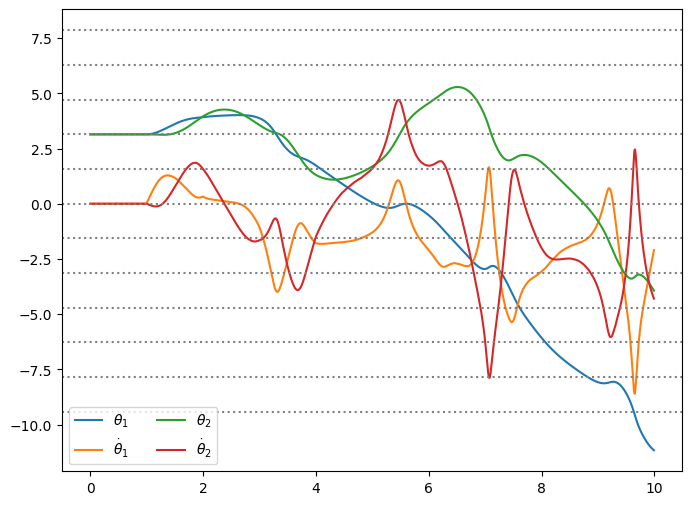

In [1007]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,4,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

cart_gt = states_gt[:t_max,0,0]
cart_vel_gt = states_gt[:t_max,3,0]
theta_1_gt = states_gt[:t_max,1,0]
theta_1_vel_gt = states_gt[:t_max,4,0]
theta_2_gt = states_gt[:t_max,2,0]
theta_2_vel_gt = states_gt[:t_max,5,0]

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(timesteps[:t_max], cart_gt, label="cart")
# ax.plot(timesteps[:t_max], cart_vel_gt, label="cart_vel")
ax.plot(timesteps[:t_max], theta_1_gt, label=r"$\theta_1$")
ax.plot(timesteps[:t_max], theta_1_vel_gt, label=r"$\dot\theta_1$")
ax.plot(timesteps[:t_max], theta_2_gt, label=r"$\theta_2$")
ax.plot(timesteps[:t_max], theta_2_vel_gt, label=r"$\dot\theta_2$")
for y in np.arange(-3*np.pi, 3*np.pi, step=np.pi/2):
    ax.axhline(y, 0, timesteps[t_max], linestyle=":", color="gray")

ax.legend(ncol=2)

In [1008]:
from matplotlib import animation
import matplotlib.patheffects as pe
from matplotlib.patches import Arrow

plt.rcParams["animation.html"] = "html5"

In [1009]:
def animate_pendulum(fig, ax, carts, theta_1s, theta_2s, controls, L1, L2, subsample=1):
    carts = carts[::subsample]
    theta_1s = theta_1s[::subsample]
    theta_2s = theta_2s[::subsample]
    controls = controls[::subsample]

    T = len(carts)

    # initialize scene
    ax.axhline(0, color="dimgray", linewidth=3, zorder=0)
    cart_marker = ax.plot(0, 0, marker="s", markersize=40, markeredgecolor="black", markerfacecolor="tab:gray", zorder=1)[0]
    link1_line = ax.plot(
        [0, 0], [0, 0], linewidth=10, solid_capstyle="round", color="tab:blue",
        path_effects=[pe.Stroke(linewidth=12, foreground="black"), pe.Normal()],
        zorder=2
    )[0]
    link2_line = ax.plot(
        [0, 0], [0, 0], linewidth=10, solid_capstyle="round", color="tab:blue",
        path_effects=[pe.Stroke(linewidth=12, foreground="black"), pe.Normal()],
        zorder=3
    )[0]
    joint1_marker = ax.plot(0, 0, marker=".", markersize=4, color="black", zorder=2)[0]
    joint2_marker = ax.plot(0, 0, marker=".", markersize=4, color="black", zorder=3)[0]

    timestamp_text = ax.text(
        0.98, 0.98, "",
        ha="right", va="top", transform=ax.transAxes,
        fontfamily="Lucida Console", fontsize=12
    )

    # precompute cartesian coordinates
    theta_1s_frame = np.pi/2 - theta_1s     # convert angles to pyplot coordinate frame
    theta_2s_frame = np.pi/2 - theta_2s
    cart_pos = np.vstack([carts, np.zeros(T)]).T
    link1_pos = cart_pos + L1 * np.vstack([np.cos(theta_1s_frame), np.sin(theta_1s_frame)]).T
    link2_pos = link1_pos + L2 * np.vstack([np.cos(theta_2s_frame), np.sin(theta_2s_frame)]).T

    # set axis limits
    L = L1 + L2
    pad = 0.2 * L
    ax.set_xlim(np.min(cart_pos[:,0]) - L - pad, np.max(cart_pos[:,0]) + L + pad)
    ax.set_ylim(-L - pad, L + pad)

    def ani_func(t):
        if t % 20 == 0: print(f"{t}/{T}")

        link1_line.set_data([cart_pos[t,0], link1_pos[t,0]], [cart_pos[t,1], link1_pos[t,1]])
        link2_line.set_data([link1_pos[t,0], link2_pos[t,0]], [link1_pos[t,1], link2_pos[t,1]])
        cart_marker.set_data([cart_pos[t,0]], [cart_pos[t,1]])
        joint1_marker.set_data([cart_pos[t,0]], [cart_pos[t,1]])
        joint2_marker.set_data([link1_pos[t,0]], [link1_pos[t,1]])

        timestamp_text.set_text(f"t = {timesteps[t*subsample]:0.1f}s")

        for p in ax.patches: p.remove()
        force = controls[t,0,0]
        if abs(force) > 0:
            arrow_len = 0.5 * np.log(abs(force))
            ax.add_patch(Arrow(
                cart_pos[t,0], 1.5, np.sign(force) * arrow_len, 0,
                facecolor="tab:orange", edgecolor=None,
                width=1.5, zorder=0
            ))
    
    ax.set_aspect("equal")

    ani = animation.FuncAnimation(fig, ani_func, frames=T, interval=1000*pendulum_system_gt.delta_t*subsample)
    plt.close()
    return ani


fig, ax = plt.subplots()
ani = animate_pendulum(
    fig, ax,
    states_gt[:,0,0], states_gt[:,1,0], states_gt[:,2,0],
    controls,
    2.0, 3.0,
    subsample=20
)
# ani
ani.save("../../figures/double_pendulum_animation.mp4")

0/100
0/100
20/100
40/100
60/100
80/100


In [1010]:
# Test all filters with the same initial belief
initial_covariance = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
initial_mean = np.random.multivariate_normal(states_gt[0,:,0], initial_covariance).reshape(-1, 1)

initial_state_estimate = (initial_mean, initial_covariance)
initial_state_estimate

(array([[-0.01927526],
        [ 3.1588499 ],
        [ 3.13927717],
        [-0.03991653],
        [ 0.03402603],
        [ 0.02005872]]),
 array([[0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.001, 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.001, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.001]]))

In [1011]:
from filters import ExtendedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
pendulum_system_approx = deepcopy(pendulum_system_gt)

pendulum_EKF = ExtendedKalmanFilter(pendulum_system_approx)

In [1012]:
# Run the filter

# initial state belief
pendulum_EKF.initialize(*initial_state_estimate)

means_EKF = np.zeros((T, 6, 1))
covariances_EKF = np.zeros((T, 6, 6))

means_EKF[0] = pendulum_EKF.mean
covariances_EKF[0] = pendulum_EKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    pendulum_EKF.predict_step(u)
    pendulum_EKF.update_step(z)

    means_EKF[t] = pendulum_EKF.mean
    covariances_EKF[t] = pendulum_EKF.covariance



100%|██████████| 1999/1999 [00:04<00:00, 470.28it/s]


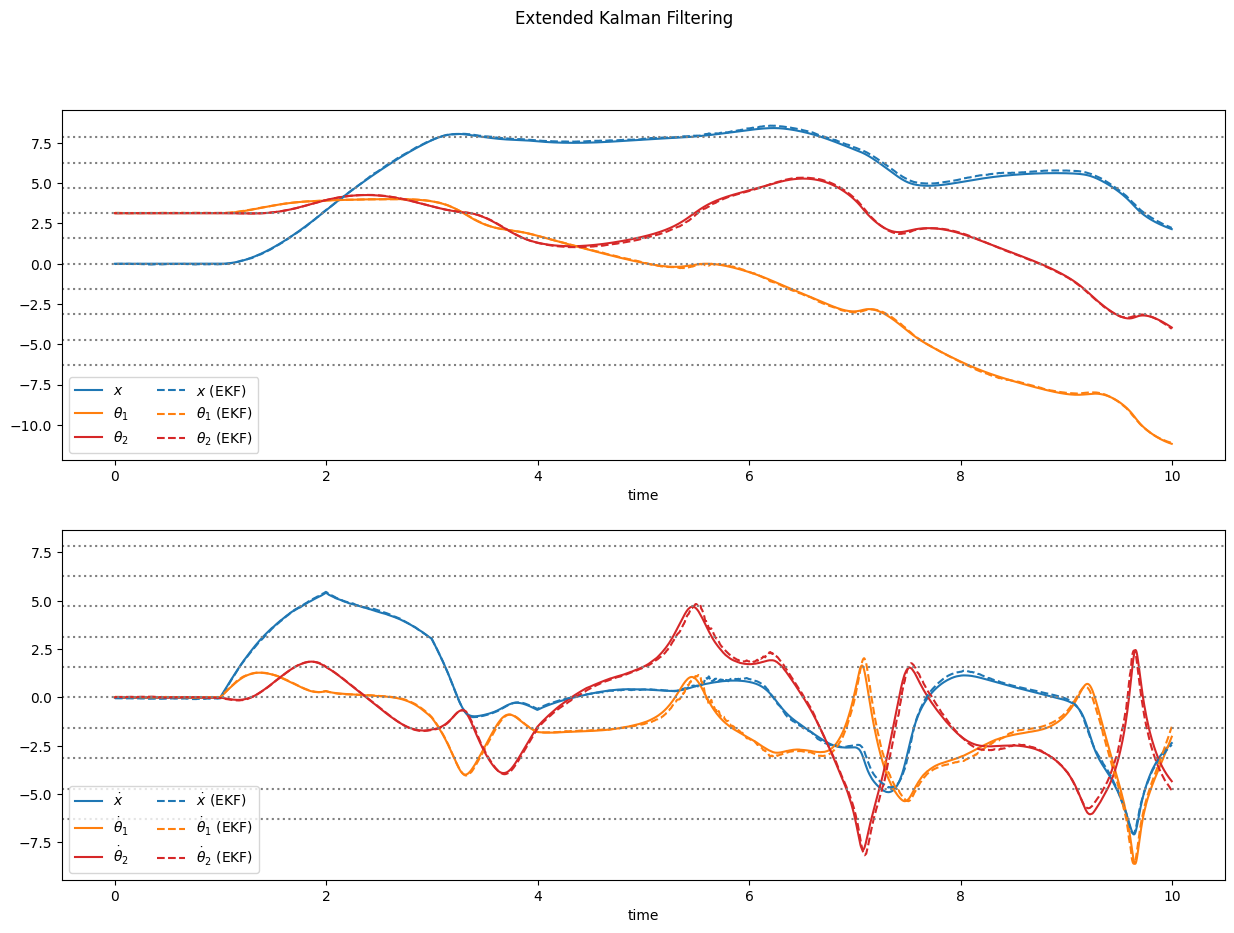

In [1013]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle("Extended Kalman Filtering")

ax1.set_xlabel("time")
ax1.plot(timesteps[:], states_gt[:,0,0], label=r"$x$", color="tab:blue")
ax1.plot(timesteps[:], states_gt[:,1,0], label=r"$\theta_1$", color="tab:orange")
ax1.plot(timesteps[:], states_gt[:,2,0], label=r"$\theta_2$", color="tab:red")
ax1.plot(timesteps[:], means_EKF[:,0,0], label=r"$x$ (EKF)", color="tab:blue", linestyle="--")
ax1.plot(timesteps[:], means_EKF[:,1,0], label=r"$\theta_1$ (EKF)", color="tab:orange", linestyle="--")
ax1.plot(timesteps[:], means_EKF[:,2,0], label=r"$\theta_2$ (EKF)", color="tab:red", linestyle="--")

for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
    ax1.axhline(y, linestyle=":", color="gray")

ax1.legend(ncol=2)

ax2.set_xlabel("time")
ax2.plot(timesteps[:], states_gt[:,3,0], label=r"$\dot x$", color="tab:blue")
ax2.plot(timesteps[:], states_gt[:,4,0], label=r"$\dot\theta_1$", color="tab:orange")
ax2.plot(timesteps[:], states_gt[:,5,0], label=r"$\dot\theta_2$", color="tab:red")
ax2.plot(timesteps[:], means_EKF[:,3,0], label=r"$\dot x$ (EKF)", color="tab:blue", linestyle="--")
ax2.plot(timesteps[:], means_EKF[:,4,0], label=r"$\dot\theta_1$ (EKF)", color="tab:orange", linestyle="--")
ax2.plot(timesteps[:], means_EKF[:,5,0], label=r"$\dot\theta_2$ (EKF)", color="tab:red", linestyle="--")

for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
    ax2.axhline(y, linestyle=":", color="gray")

ax2.legend(ncol=2)

In [1014]:
from filters import UnscentedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
pendulum_system_approx = deepcopy(pendulum_system_gt)

pendulum_UKF = UnscentedKalmanFilter(pendulum_system_approx)

In [1015]:
# Run the filter

# initial state belief
pendulum_UKF.initialize(*initial_state_estimate)

means_UKF = np.zeros((T, 6, 1))
covariances_UKF = np.zeros((T, 6, 6))

means_UKF[0] = pendulum_UKF.mean
covariances_UKF[0] = pendulum_UKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    pendulum_UKF.predict_step(u)
    pendulum_UKF.update_step(z)

    means_UKF[t] = pendulum_UKF.mean
    covariances_UKF[t] = pendulum_UKF.covariance



100%|██████████| 1999/1999 [00:04<00:00, 440.03it/s]


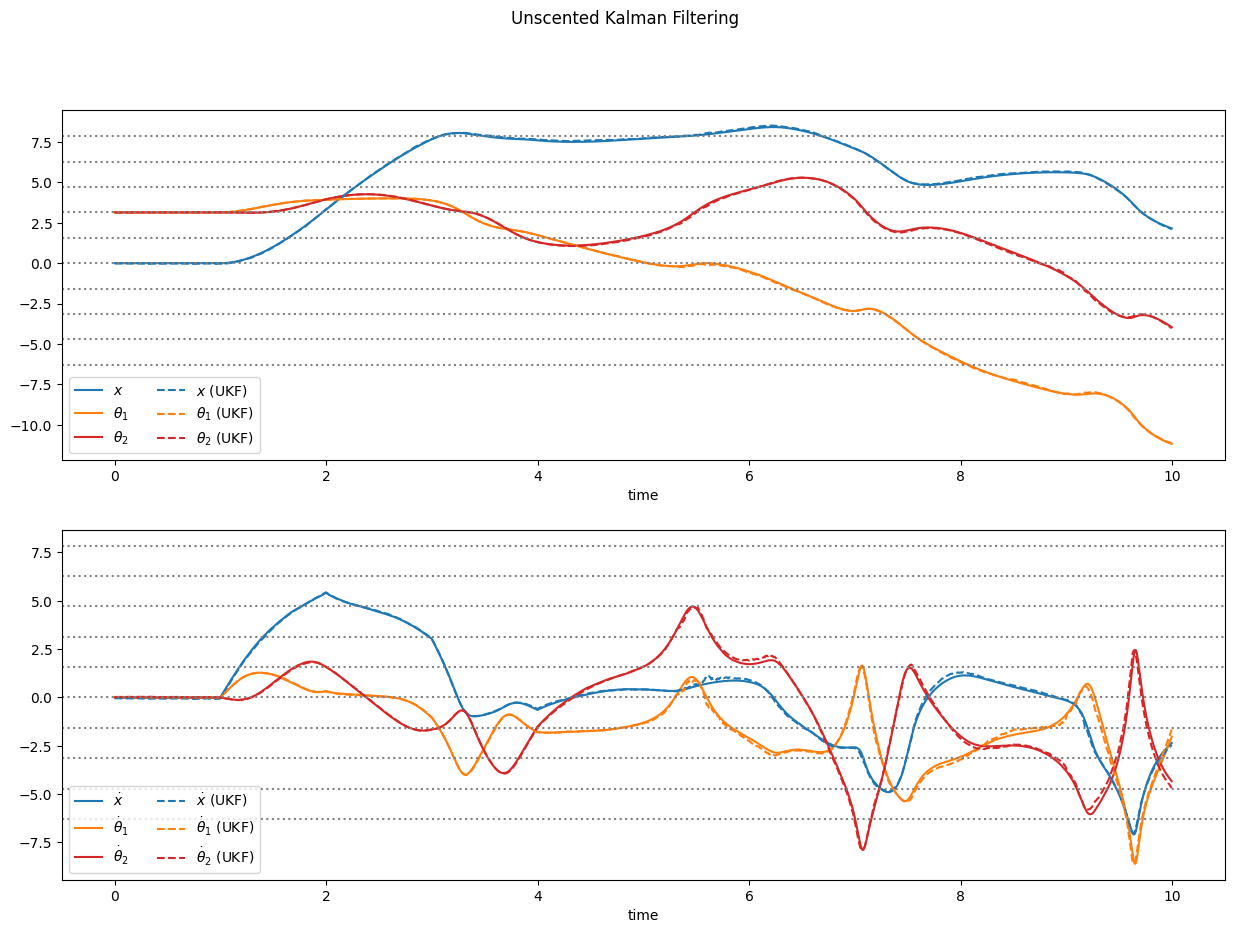

In [1016]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle("Unscented Kalman Filtering")

ax1.set_xlabel("time")
ax1.plot(timesteps[:], states_gt[:,0,0], label=r"$x$", color="tab:blue")
ax1.plot(timesteps[:], states_gt[:,1,0], label=r"$\theta_1$", color="tab:orange")
ax1.plot(timesteps[:], states_gt[:,2,0], label=r"$\theta_2$", color="tab:red")
ax1.plot(timesteps[:], means_UKF[:,0,0], label=r"$x$ (UKF)", color="tab:blue", linestyle="--")
ax1.plot(timesteps[:], means_UKF[:,1,0], label=r"$\theta_1$ (UKF)", color="tab:orange", linestyle="--")
ax1.plot(timesteps[:], means_UKF[:,2,0], label=r"$\theta_2$ (UKF)", color="tab:red", linestyle="--")

for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
    ax1.axhline(y, linestyle=":", color="gray")

ax1.legend(ncol=2)

ax2.set_xlabel("time")
ax2.plot(timesteps[:], states_gt[:,3,0], label=r"$\dot x$", color="tab:blue")
ax2.plot(timesteps[:], states_gt[:,4,0], label=r"$\dot\theta_1$", color="tab:orange")
ax2.plot(timesteps[:], states_gt[:,5,0], label=r"$\dot\theta_2$", color="tab:red")
ax2.plot(timesteps[:], means_UKF[:,3,0], label=r"$\dot x$ (UKF)", color="tab:blue", linestyle="--")
ax2.plot(timesteps[:], means_UKF[:,4,0], label=r"$\dot\theta_1$ (UKF)", color="tab:orange", linestyle="--")
ax2.plot(timesteps[:], means_UKF[:,5,0], label=r"$\dot\theta_2$ (UKF)", color="tab:red", linestyle="--")

for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
    ax2.axhline(y, linestyle=":", color="gray")

ax2.legend(ncol=2)